# HDDM analysis of EMBARC PRT data 

In [1]:
import datetime, mmap,os,re, sys, hddm, decimal 
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
# below makes graphs open in the nb instead of in a separate window
% matplotlib inline 
%reload_ext rpy2.ipython

# R
%R library(ez)
%R library(lmerTest)
%R library(lsmeans)
%R lsm.options(disable.pbkrtest=TRUE)
#%R library(mutoss)
%R library(sjPlot)
%R library(sjmisc)
#%R library(coefplot2)

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘lmerTest’


  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmer


  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2

array(['sjmisc', 'sjPlot', 'lsmeans', 'estimability', 'lmerTest', 'lme4',
       'Matrix', 'ez', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='<U12')

In [2]:
uname = !whoami
uname = uname[0]
path2analysis = '/Users/' + uname + '/Work/Expts/EMBARC/' # also where git repo lives
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [3]:
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/' + state + '/'
    temp_dir = base_dir + abrev + 'Temp/'
    old_files = base_dir + 'embarc_CU_' + abrev + '0*/done/sigdet_output*out'
    flist = !ls {old_files}
    
    !mkdir {temp_dir}
    
    for old_fname in flist:
        if abrev != 'CU':
            sub = old_fname.split('_')[2]
        else:
            sub = old_fname.split('_')[3]
        new_file = sub + '_out.txt'
        new_fname = temp_dir + new_file
        
        !cp {old_fname} {new_fname} # Done this way you don't get error messages when there's no old file

mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/: File exists
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Michigan/UMTemp/: File exists
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/New_York/CUTemp/: File exists
usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvX] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvX] source_file ... target_directory
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/: File exists


In [4]:
def SigDetParse(fname):
    '''Open the file, use regex to pull out key vars, output a clean df.'''
    
    df = []
    d = {}
    ct = 0
    
    # Begin reading in data from the line including 'reward_due', as that's unlikely to occur anywhere earlier
    with open(fname) as f:
        for line in f:
            if 'reward_due' in line:
                for line in f:
                    d[ct] = {'trial':line.split('\t')[0],
                             'length':line.split('\t')[1],
                             'time':line.split('\t')[2], # tempting to change to RT but keep same for backwards compat
                             'key_press':line.split('\t')[3],
                             'correct':line.split('\t')[4],
                             'did_reward':line.split('\t')[5],
                             'reward_due':line.split('\t')[6],
                             'rich_due':line.split('\t')[7],
                             'lean_due':line.split('\t')[8],
                             'outlier':line.split('\t')[9].strip('\n')}
                    ct = ct + 1
    df = pd.DataFrame.from_dict(d,orient='index')
    

    for val in [('rich_key','Rich key:'),('lean_key','Lean key:'), ('subject','Subject ID:'), ('date','Date:'), 
                ('bias','Bias:'), ('rich_stim','Rich stimulus:'), ('lean_stim','Lean stimulus:')]:
        
        var_name, pattern = val
        df[var_name] = np.nan # Need some default values b/c some subjects have missing data        

        if var_name != 'date':
            var_def = re.compile(pattern + '[\s]+([\w]+)')
        else:
            var_def = re.compile(pattern + '[\s]+([\d]+/[\d]+/[\d]+)')
        
        with open(fname) as f:
            for line in f:
                var_match = var_def.search(line)
                if var_match:
                    result = var_match.group(1)
                    #checks if the subject ID is weird, prints it, and fixes it. For this data, all 3 digit sub ids
                    #are fixed by adding a 0 to the beginning. 
                    if var_name =='subject' and len(result) !=4:
                        print ('Check sub ID: ' + fname)
                        if len(result) == 3:
                            df[var_name]='0'+ result
                        if len(result) == 1:
                            df[var_name] ='000' + result
                    else:
                        df[var_name] = result

    return df

In [9]:
# Now you can just iterate over the files in each dir and use the code above to read each file into a ginorm df
today = datetime.datetime.today().strftime("%m_%d_%Y")

dfs = []
base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/'
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    state_dir = base_dir + state + '/' + abrev + 'Temp'
    flist = !ls {state_dir}
    
    for fname in flist:
        curr_path = state_dir + '/' + fname 
        statinfo = os.stat(curr_path) # checking for empty files b/c I found one . . .
        if statinfo.st_size == 0:
            #to make it compatible with 2 & 3
            print ('Empty file: '+ curr_path)
        else:
            df = SigDetParse(curr_path)
            df['site'] = abrev
            df['ProjectSpecificID'] = df['site'] + df['subject']
            dfs.append(df)
out = pd.concat(dfs)
out = out[['ProjectSpecificID','site','subject','date','bias','rich_stim','lean_stim','rich_key','lean_key',
           'trial','length','time','key_press','correct','did_reward','reward_due','rich_due','lean_due','outlier']]
out.to_csv(path2analysis + 'Data/embarc_PRT_all_trials_all_sessions_' + today + ' .csv')

Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0020MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0025MGBP2R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0027MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0039MGBP2R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0270MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Michigan/UMTemp/UM0001UMBP1R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/TX0038MGBP3R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/TX0198TXBP2R1_out.txt


In [10]:
out.head()

,ProjectSpecificID,site,subject,date,bias,rich_stim,lean_stim,rich_key,lean_key,trial,length,time,key_press,correct,did_reward,reward_due,rich_due,lean_due,outlier
0,MG0001,MG,0001,12/14/2011,short,short,long,c,m,1,short,683,c,1,0,0,0,0,0
1,MG0001,MG,0001,12/14/2011,short,short,long,c,m,2,long,1307,c,0,0,1,0,1,1
2,MG0001,MG,0001,12/14/2011,short,short,long,c,m,3,short,577,c,1,1,1,0,1,0
3,MG0001,MG,0001,12/14/2011,short,short,long,c,m,4,long,677,m,1,1,1,0,0,0
4,MG0001,MG,0001,12/14/2011,short,short,long,c,m,5,short,724,c,1,0,0,0,0,0


In [11]:
out.tail()

,ProjectSpecificID,site,subject,date,bias,rich_stim,lean_stim,rich_key,lean_key,trial,length,time,key_press,correct,did_reward,reward_due,rich_due,lean_due,outlier
195,TX0204,TX,0204,10/12/2015,short,short,long,c,m,196,short,686,m,0,0,1,1,0,0
196,TX0204,TX,0204,10/12/2015,short,short,long,c,m,197,long,365,m,1,1,1,1,0,0
197,TX0204,TX,0204,10/12/2015,short,short,long,c,m,198,long,846,m,1,0,0,1,0,0
198,TX0204,TX,0204,10/12/2015,short,short,long,c,m,199,short,414,c,1,1,1,0,0,0
199,TX0204,TX,0204,10/12/2015,short,short,long,c,m,200,short,1083,c,1,0,0,0,0,0


In [12]:
# Check that change fixed the wacky numbers, looks like it did
out.subject.unique()

array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
       '0018', '0020', '0021', '0025', '0026', '0027', '0028', '0030',
       '0032', '0039', '0040', '0051', '0060', '0064', '0066', '0069',
       '0070', '0074', '0076', '0081', '0086', '0101', '0104', '0106',
       '0112', '0116', '0117', '0120', '0125', '0126', '0135', '0137',
       '0138', '0142', '0152', '0155', '0157', '0158', '0161', '0164',
       '0168', '0172', '0180', '0182', '0185', '0187', '0198', '0202',
       '0206', '0207', '0209', '0213', '0214', '0218', '0220', '0222',
       '0228', '0230', '0231', '0238', '0239', '0242', '0243', '0246',
       '0248', '0251', '0252', '0253', '0256', '0257', '0259', '0261',
       '0269', '0270', '0009', '0011', '0012', '0014', '0015', '0016',
       '0017', '0023', '0024', '0029', '0031', '0033', '0034', '0035',
       '0036', '0037', '0038', '0042', '0046', '0047', '0048', '0049',
       '0050', '0052', '0056', '0058', '0065', '0073', '0077', '0078',
      

In [13]:
#Combines the group data (groups.csv) with the task data, is really big, prob best to not work with
#Excel won't even open this
df_task = out
df_group = []
df_all = []

df_group = pd.read_csv('Data/groups.csv',encoding="latin-1")
df_all = df_task.merge(df_group, how='outer')
df_all = df_all[pd.notnull(df_all['ProjectSpecificID'])]
df_all.to_csv('Data/embarc_combined_' + today +'.csv')

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,104,109,113,117,118,119,122,123,127,133,134,135,136,138,141,142,219,221,227,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,250,251,252,253,258,260,262,264,266,268,276,280,283,285,287,290,293,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,336,338,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,392,396,408,410,411,417,418,419,421,422,423,460,462,464,466,468,470,472,474,476,478,480,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,590,800,801,812,813,814,823,861) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
list(df_all)

['ProjectSpecificID',
 'site',
 'subject',
 'date',
 'bias',
 'rich_stim',
 'lean_stim',
 'rich_key',
 'lean_key',
 'trial',
 'length',
 'time',
 'key_press',
 'correct',
 'did_reward',
 'reward_due',
 'rich_due',
 'lean_due',
 'outlier',
 'sample',
 'feasibility',
 'trainingset',
 'aaq_1',
 'aaq_2',
 'aaq_3',
 'aaq_4',
 'aaq_5a',
 'aaq_5b',
 'aaq_5c',
 'aaq_5d',
 'aaq_5e',
 'aaq_5f',
 'aaq_5g',
 'aaq_5h',
 'aaq_5i',
 'aaq_5j',
 'aaq_5k',
 'aaq_5l',
 'aaq_5m',
 'aaq_6',
 'aaq_7',
 'aaq_score_result',
 'asrm_4',
 'asrm_5',
 'asrm_3',
 'asrm_2',
 'asrm_1',
 'asrm_score2',
 'atrq_01',
 'atrq_02ada1',
 'atrq_02ada2',
 'atrq_02ana1',
 'atrq_02ana2',
 'atrq_02ase2',
 'atrq_02ase1',
 'atrq_02end2',
 'atrq_02end1',
 'atrq_02lud1',
 'atrq_02lud2',
 'atrq_02nor1',
 'atrq_02nor2',
 'atrq_02pam1',
 'atrq_02pam2',
 'atrq_02sin1',
 'atrq_02sin2',
 'atrq_02sur1',
 'atrq_02sur2',
 'atrq_02tof1',
 'atrq_02tof2',
 'atrq_02viv1',
 'atrq_02viv2',
 'atrq_02mar1',
 'atrq_02mar2',
 'atrq_02nar1',
 'atrq_02na

In [18]:
df_compact = []
df_compact = df_group[['ProjectSpecificID', 'feasibility']]

In [19]:
# number of outlier trials (1.0) in ALL sessions
print (df_all["outlier"].value_counts())

0    144210
1      4030
Name: outlier, dtype: int64


In [20]:
# MOVE THIS DOWN!!!!!!!!!!!!!!!!!!!!

# Much better way to get the first session by merging with standard analysis data and taking the first session. I need 
# to move the order of the cells around to make it more intuitive, this should come after the standard analysis stuff.

df_reuse = df_all.merge(standardfinal)
df_reuse = df_reuse[pd.notnull(df_reuse['ProjectSpecificID'])]

# renaming time & correct; the hddm package requires specific column names
df_reuse.rename(columns={'time':'rt', 'correct': 'response', 'ProjectSpecificID': 'subj_idx'}, inplace = True)

# number of outlier trials and non-outlier trials for the FIRST session
print(df_reuse["outlier"].value_counts())

# don't include the outlier trials
df_reuse = df_reuse[df_reuse.outlier != 1]

# save it as embarc_compact...
df_reuse.to_csv('embarc_compact_first_sess' + today + '.csv')

NameError: name 'standardfinal' is not defined

In [ ]:
df_dupesdropped = df_reuse.drop_duplicates
#%Rpush df_dupesdropped
#%R cat <- ezPlot(data = df_dupesdropped, dv = RB_adjst_all_Blk2_minus_Blk1, between = (feasibility, site), x= feasibility, wid=ProjectSpecificID)
#%R print(cat)
#%R ay <- ezANOVA(data = df_mg, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, wid=ProjectSpecificID)
#%R print(ay)

**Dan note:** So far so good! Please count the number of outlier trials and the % of trials that are outliers.

# Standard Analysis

## Notes:
#### Massachusetts:
MG0081 & MG0164 had two sessions labled '1.' Since both sessions were complete, the ones with the earlier dates were used. Christian included MG020, which was originally coded as only having a session two; this was probably a typo and I included it. After these corrections everything matched, except that Christian's list included MG0164 twice (so our n for MDDs is one less than his). 

Our descriptives look the same as Christian's after dropping MG0020's second session and using the one on 10/17. The way it was initially coded it was keeping the old one. 

#### New York: 
CU0017, CU0018, and CU0019 had two sessions labled '1.' Since both sessions were complete and had all data I just took the ones with the earlier dates. Christian also excluded CU0047, so I removed them from ours. It's unclear from the data why they were excluded. 

Our descriptives look the same as Christian's.
#### Michigan:
UM0012 & UM0017 had two sessions labled '1.' Since both sessions were complete I took the first of the two for each. UM0016 had three lines of the exact same session 1 data, so I only included the first line. Christian also excluded UM0102, so I removed them from ours. It's unclear from the data why they were excluded.

Our descriptives look the same as Christian's except our MDD n is 51 and his is 52. I would guess that UM0102 was not included in the list of subIDs that were included, but was included when doing the descriptives. We should decide whether or not to keep this person. 
#### Texas:
Everything lined up with no alterations!

Our descriptives look the same as Christian's.

**Dan note:** Above looks good, for us you might also check whether including the second set of session 1 data for people with duplicates makes any difference.

In [ ]:
#-------------DELETE SOON-------------------

def replacetabs(state):
    '''Open the file, replace the tabs with spaces, save the new doc as a csv.'''
    !mkdir {'/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/Temp'}
    statesum = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/embarc*/*txt'
    folders = !ls -d {statesum}
    newfolders = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/Temp/'
    newfolders2 = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/Temp'
    dfall = []
    for file in folders:
        !cp {file} {newfolders}
    for filename in os.listdir(newfolders):
        if filename != 'embarc_MG_subj_PRTsess_.txt' and filename != 'embarc_NY_subj_PRTsess_.txt'and filename != 'embarc_NY_subj****************_PRTsess2_short.txt' and filename != 'embarc_TX_subj_PRTsess_.txt' and filename != 'embarc_UM_subj_PRTsess_.txt' and filename !='Note.txt':
            f = open(newfolders + filename, 'r', encoding='windows-1252')
            for eachline in f:
                string=re.sub(r'\t',' ',eachline)
                open('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/' + state +'/Summaries/'+ filename,'a').write(string)
                df_this = pd.read_csv('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/' + state +'/Summaries/'+ filename, ' ', dtype={'subject':str})
                dfall.append(df_this)
    out = pd.concat(dfall)      
    out.to_csv('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/Standard' +state+ '.csv')

    #-------------DELETE SOON------------------

In [21]:
# for all states extract the standard data and put into one file

df_stand = pd.DataFrame()
for state in ['Massachusetts', 'Michigan', 'New_York', 'Texas']:
    df_state = pd.DataFrame()
    statesum = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/embarc*/*txt'
    folders  = !ls -d {statesum}
    
    for filename in folders:
        if filename != 'embarc_MG_subj_PRTsess_.txt' and filename != 'embarc_NY_subj_PRTsess_.txt'and filename != 'embarc_NY_subj****************_PRTsess2_short.txt' and filename != 'embarc_TX_subj_PRTsess_.txt' and filename != 'embarc_UM_subj_PRTsess_.txt' and filename !='Note.txt':
            x = pd.read_csv(filename, delim_whitespace = True, dtype={'subject':str, 'PRT_QC_Status':str, 'session':str})
            if 'subject' in x.columns:
                x.subject = x.subject.str.zfill(4) #fixing weird IDs
                df_stand = pd.concat([x, df_stand])
                df_state = pd.concat([x, df_state])
        
    df_state['ProjectSpecificID'] = df_state['site'] + df_state['subject'] 
    df_state = df_state[pd.notnull(df_state['subject'])]
    df_state = df_state[df_state.subject != '****************'] #we don't care about this person
    df_state.loc[df_state['site'] == 'NY', 'site'] = 'CU'# it's NY in this file
    df_state.to_csv('standard_' + state + '_' + today + '.csv')

df_stand = df_stand[df_stand.subject != '****************']
df_stand = df_stand[pd.notnull(df_stand['subject'])]
df_stand.loc[df_stand['site'] == 'NY', 'site'] = 'CU'
df_stand['ProjectSpecificID'] = df_stand['site'] + df_stand['subject']
df_stand.to_csv('standard_all_sessions_all_states_' + today + '.csv')

In [22]:
df_stand.ProjectSpecificID.unique()

array(['TX0204', 'TX0198', 'TX0195', 'TX0194', 'TX0193', 'TX0189',
       'TX0188', 'TX0187', 'TX0184', 'TX0182', 'TX0179', 'TX0178',
       'TX0177', 'TX0175', 'TX0174', 'TX0173', 'TX0172', 'TX0169',
       'TX0165', 'TX0162', 'TX0159', 'TX0156', 'TX0155', 'TX0153',
       'TX0152', 'TX0151', 'TX0149', 'TX0148', 'TX0147', 'TX0145',
       'TX0142', 'TX0141', 'TX0140', 'TX0139', 'TX0137', 'TX0136',
       'TX0135', 'TX0134', 'TX0133', 'TX0132', 'TX0130', 'TX0129',
       'TX0127', 'TX0126', 'TX0124', 'TX0123', 'TX0122', 'TX0119',
       'TX0117', 'TX0115', 'TX0114', 'TX0112', 'TX0110', 'TX0108',
       'TX0107', 'TX0106', 'TX0103', 'TX0101', 'TX0100', 'TX0097',
       'TX0096', 'TX0095', 'TX0094', 'TX0093', 'TX0092', 'TX0091',
       'TX0090', 'TX0088', 'TX0086', 'TX0085', 'TX0084', 'TX0083',
       'TX0079', 'TX0078', 'TX0074', 'TX0071', 'TX0070', 'TX0068',
       'TX0067', 'TX0066', 'TX0065', 'TX0063', 'TX0062', 'TX0061',
       'TX0060', 'TX0059', 'TX0055', 'TX0050', 'TX0047', 'TX00

In [23]:
list(df_stand)

['site',
 'subject',
 'session',
 'date1',
 't1',
 'bias1',
 'rhkey1',
 'lnkey1',
 'strt1_1',
 'end_1_1',
 'vldtrl1_1',
 'rhct1_1',
 'lnct1_1',
 'corct1_1',
 'rhcor1_1',
 'lncor1_1',
 'rwdct1_1',
 'rhrwd1_1',
 'lnrwd1_1',
 'blthr1_1',
 'abthr1_1',
 'moout1_1',
 'out_1_1',
 'avT1_1',
 'avrhT1_1',
 'avlnT1_1',
 'minT1_1',
 'maxT1_1',
 'sdT1_1',
 'ac1_1',
 'rhac1_1',
 'lnac1_1',
 'RB_pure1_1',
 'RB_adjst_zeros1_1',
 'RB_adjst_all1_1',
 'dis_pure1_1',
 'dis_adjst_zeros1_1',
 'dis_adjst_all1_1',
 'strt1_2',
 'end_1_2',
 'vldtrl1_2',
 'rhct1_2',
 'lnct1_2',
 'corct1_2',
 'rhcor1_2',
 'lncor1_2',
 'rwdct1_2',
 'rhrwd1_2',
 'lnrwd1_2',
 'blthr1_2',
 'abthr1_2',
 'moout1_2',
 'out_1_2',
 'avT1_2',
 'avrhT1_2',
 'avlnT1_2',
 'minT1_2',
 'maxT1_2',
 'sdT1_2',
 'ac1_2',
 'rhac1_2',
 'lnac1_2',
 'RB_pure1_2',
 'RB_adjst_zeros1_2',
 'RB_adjst_all1_2',
 'dis_pure1_2',
 'dis_adjst_zeros1_2',
 'dis_adjst_all1_2',
 'strt1_Total',
 'end_1_Total',
 'vldtrl1_Total',
 'rhct1_Total',
 'lnct1_Total',
 'corct1

**Dan note:** I'm not sure why you're replacing tabs with spaces--is this a preamble to reading the files into a df? If so, it's not necessary as you can set delim_whitespace = True. If it's a question of extracting a subset of variables from these files, you can right a regex that looks for whitespace whether it's a tab or a space. Would either of those solutions work? They seem like they would be more streamlined and easier to manage.

**VL:** delim_whitespace = True is 1000X easier, thanks!!

In [64]:
# FIX THIS SO THAT IT DOESNT INCLUDE TRIAL DATA--IT MESSES US UP LATER
# ^^I think I fixed this? 

df_group_comp = df_compact[pd.notnull(df_compact['feasibility'])] # only care where there is a val for feasibility
df_group_comp = df_group_comp.loc[df_group_comp['feasibility'] != 2] # don't care if it's 2
   
df_group_comp.loc[df_group_comp['feasibility'] == 1, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 3, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 5, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 4, 'feasibility'] = 'CTL'# make the feasibility clearer (and strs for HDDM)
    
df_stand_clean = df_stand.merge(df_group_comp, how='outer')# merge on the compact groups data
df_stand_clean.loc[df_stand_clean['ProjectSpecificID'] == 'MG0020', 'session'] = '1' #recode this presumed typo
df_stand_clean = df_stand_clean.loc[df_stand_clean['PRT_QC_Status'] == '1']
df_stand_clean = df_stand_clean[pd.notnull(df_stand_clean['feasibility'])]
df_firstsess = df_stand_clean.loc[df_stand_clean['session'] == '1']
df_firstsess['ID_date'] = df_firstsess['ProjectSpecificID'] + df_firstsess['date1']
df_firstsess = df_firstsess[df_firstsess.ID_date != 'MG002010_24_2012'] #for some reason the second date was listed first
df_firstsess = df_firstsess.drop_duplicates('ProjectSpecificID') # takes the first session listed for each participant
                                                               # we should try playing around with this for MA since our
                                                               # descriptives are slightly different from Christians
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'CU0019'] 
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'UM0102']
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'MG0026']
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'CU0047'] # based on Christian's data, remove 
                                                                               # these subjects 
# Comparing to Christian's list
df_christian = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/christian_included.txt', header = None)    
christian_list = df_christian[0].astype(str)

# are we missing anything?
for subject in christian_list:
    if subject in df_firstsess.ProjectSpecificID.unique():
        pass
    else:
        print('Missing from ours: '+ subject)

# do we have anything extra?
for subject in df_firstsess.ProjectSpecificID:
    if subject in christian_list.unique():
        pass
    else:
        print('Not included in Christians: ' + subject)
    
#save the first session file
df_firstsess.to_csv('embarc_standard_first_session_clean.csv')
list(df_group_comp)

/Users/mlm2/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['ProjectSpecificID', 'feasibility']

## Accuracy

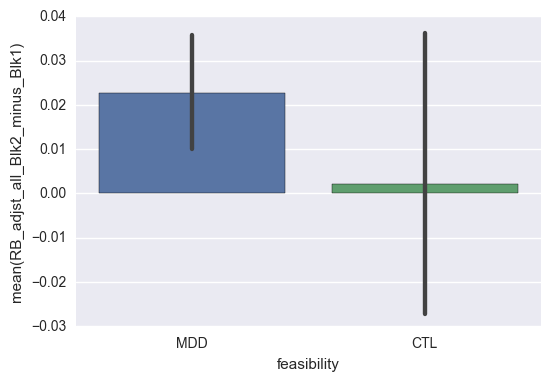

In [66]:
b = sns.barplot(y='RB_adjst_all_Blk2_minus_Blk1', x = 'feasibility', data=df_firstsess, ci=68)

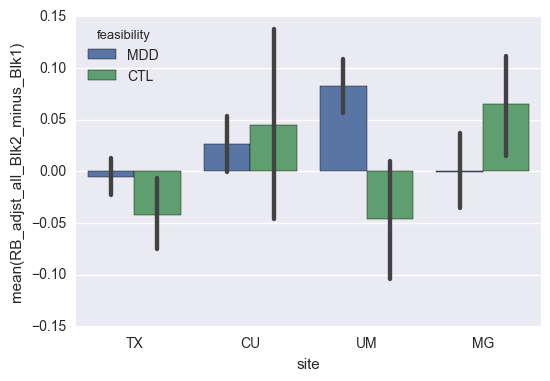

In [67]:
c = sns.barplot(y='RB_adjst_all_Blk2_minus_Blk1', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


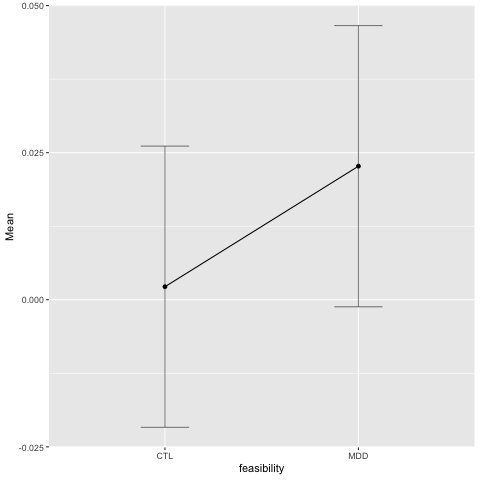

$ANOVA
            Effect DFn DFd         F         p p<.05         ges
1      feasibility   1 286 0.4672781 0.4947955       0.001631174
2             site   3 286 1.5613059 0.1989520       0.016113439
3 feasibility:site   3 286 1.2512595 0.2914352       0.012955063

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn      SSd        F          p p<.05
1   7 286 0.283015 4.849712 2.384303 0.02200693     *



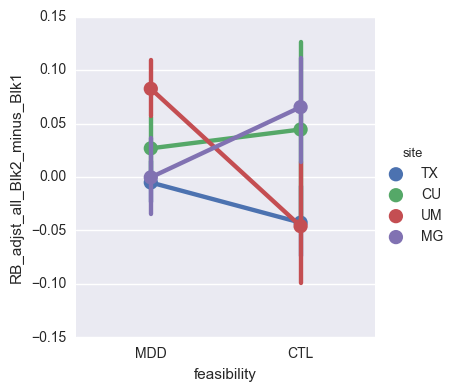

In [71]:
a = sns.factorplot(y='RB_adjst_all_Blk2_minus_Blk1', x= 'feasibility', hue='site', ci=68, data=df_firstsess)
%Rpush df_firstsess
%R cat <- ezPlot(data = df_firstsess, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, x= feasibility, wid=ProjectSpecificID)
%R print (cat)
%R ay <- ezANOVA(data = df_firstsess, dv = RB_adjst_all_Blk2_minus_Blk1, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(ay)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd         F         p p<.05         ges
1      feasibility   1 286 0.6096871 0.4355514       0.002127238
2             site   3 286 2.0893061 0.1017827       0.021445796
3 feasibility:site   3 286 0.1310084 0.9415941       0.001372328

$`Levene's Test for Homogeneity of Variance`
  DFn DFd       SSn      SSd        F         p p<.05
1   7 286 0.1104169 3.330338 1.354613 0.2245704      



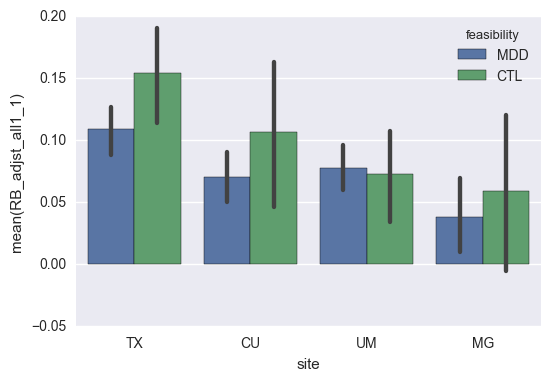

In [144]:
block1 = sns.barplot(y='RB_adjst_all1_1', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = RB_adjst_all1_1, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd            F         p p<.05          ges
1      feasibility   1 286 0.0006864711 0.9791156       2.400243e-06
2             site   3 286 1.7437579331 0.1581952       1.796261e-02
3 feasibility:site   3 286 1.8135763565 0.1448047       1.866839e-02

$`Levene's Test for Homogeneity of Variance`
  DFn DFd       SSn     SSd        F         p p<.05
1   7 286 0.1891134 5.10785 1.512698 0.1625664      



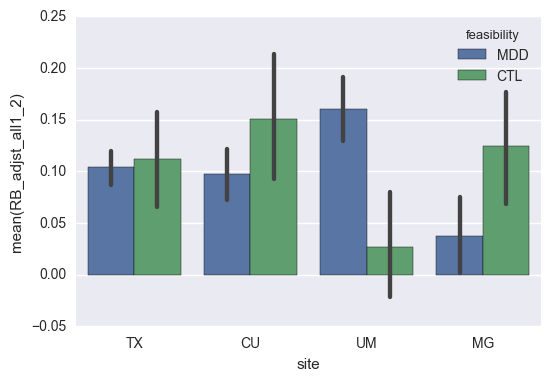

In [145]:
block2 = sns.barplot(y='RB_adjst_all1_2', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = RB_adjst_all1_2, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

## Reaction Time

##### Both Blocks

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F          p p<.05        ges
1      feasibility   1 286 6.055720 0.01445219     * 0.02073481
2             site   3 286 3.269185 0.02168945     * 0.03315519
3 feasibility:site   3 286 1.409610 0.24014281       0.01457067

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F        p p<.05
1   7 286 80792.38 2037472 1.620119 0.129372      



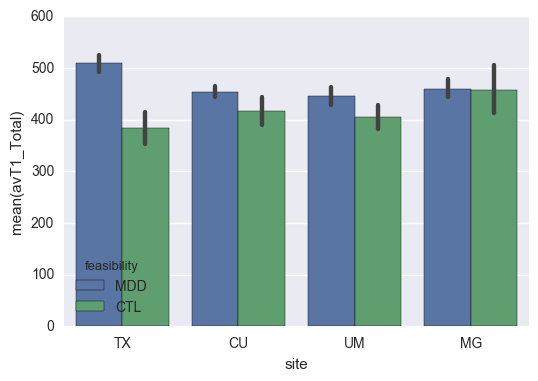

In [136]:
# All Trials
rts = sns.barplot(y='avT1_Total', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avT1_Total, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F          p p<.05        ges
1      feasibility   1 286 6.485729 0.01139854     * 0.02217451
2             site   3 286 3.101433 0.02708813     * 0.03150750
3 feasibility:site   3 286 1.448696 0.22883103       0.01496865

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F         p p<.05
1   7 286 68682.37 2010977 1.395424 0.2069317      



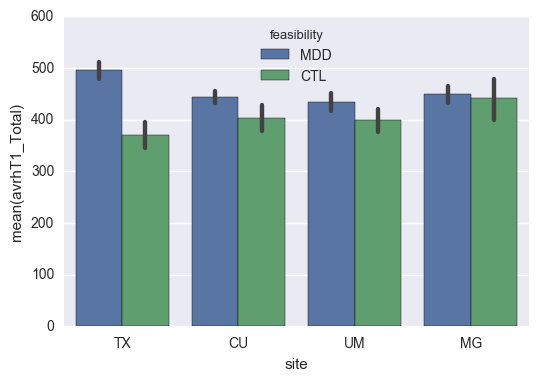

In [137]:
rts = sns.barplot(y='avrhT1_Total', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avrhT1_Total, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F          p p<.05        ges
1      feasibility   1 286 5.413298 0.02068246     * 0.01857602
2             site   3 286 3.280403 0.02136903     * 0.03326518
3 feasibility:site   3 286 1.332045 0.26413327       0.01377996

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F         p p<.05
1   7 286 101086.6 2436682 1.694972 0.1099262      



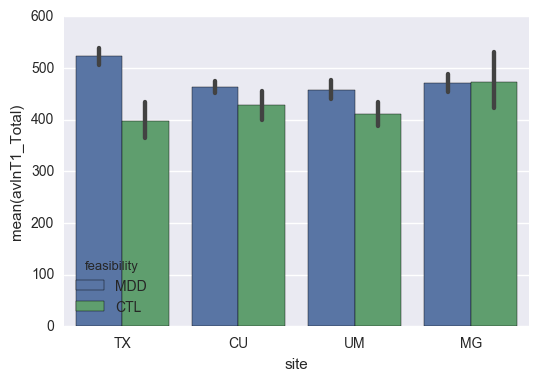

In [138]:
rts = sns.barplot(y='avlnT1_Total', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avlnT1_Total, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

##### First Block

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F           p p<.05        ges
1      feasibility   1 286 6.987232 0.008662058     * 0.02384825
2             site   3 286 2.533346 0.057202950       0.02588568
3 feasibility:site   3 286 1.471301 0.222516869       0.01519866

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F         p p<.05
1   7 286 81139.11 2048891 1.618004 0.1299633      



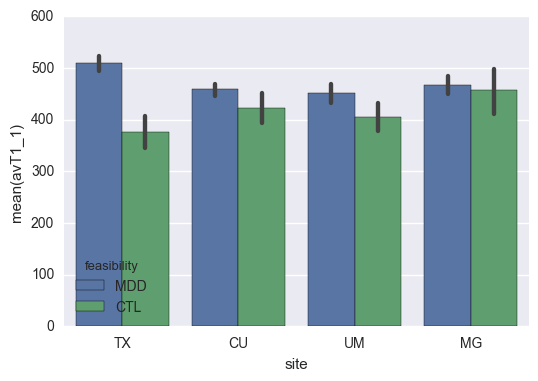

In [129]:
# All Trials
rts = sns.barplot(y='avT1_1', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avT1_1, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F          p p<.05        ges
1      feasibility   1 286 7.366842 0.00704726     * 0.02511136
2             site   3 286 2.716531 0.04499692     * 0.02770561
3 feasibility:site   3 286 1.401388 0.24258723       0.01448692

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F         p p<.05
1   7 286 72875.77 1978611 1.504841 0.1652609      



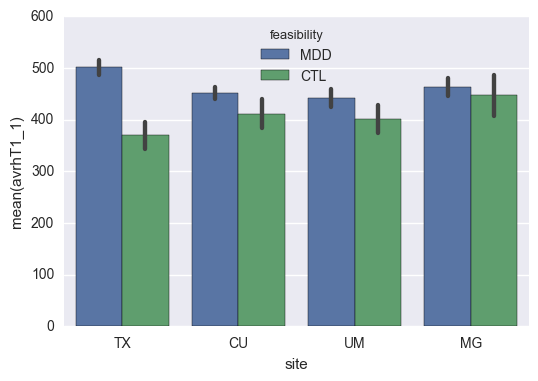

In [131]:
# Rich Trials
rts = sns.barplot(y='avrhT1_1', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avrhT1_1, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F          p p<.05        ges
1      feasibility   1 286 6.205475 0.01330266     * 0.02123668
2             site   3 286 2.226582 0.08525694       0.02282271
3 feasibility:site   3 286 1.465414 0.22414551       0.01513877

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F         p p<.05
1   7 286 91476.47 2384248 1.567566 0.1447853      



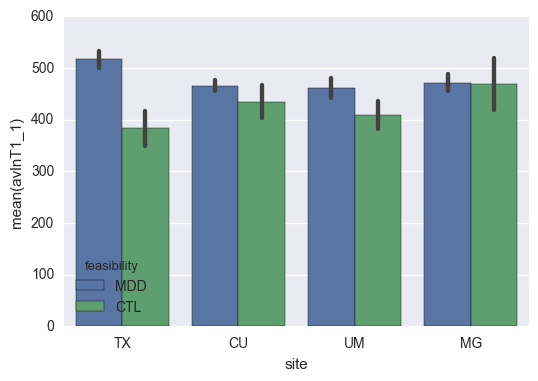

In [132]:
# Lean Trials
rts = sns.barplot(y='avlnT1_1', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avlnT1_1, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

##### Second Block

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F          p p<.05        ges
1      feasibility   1 286 4.579105 0.03321021     * 0.01575855
2             site   3 286 3.720105 0.01190500     * 0.03755655
3 feasibility:site   3 286 1.219946 0.30268848       0.01263495

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F         p p<.05
1   7 286 85062.99 2351676 1.477853 0.1748113      



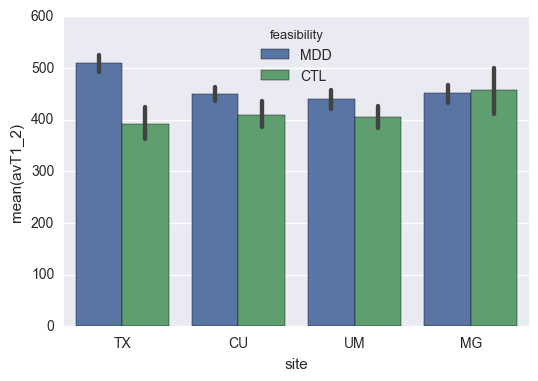

In [133]:
# All Trials
rts = sns.barplot(y='avT1_2', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avT1_2, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F          p p<.05        ges
1      feasibility   1 286 4.860078 0.02828126     * 0.01670933
2             site   3 286 3.193746 0.02397117     * 0.03241491
3 feasibility:site   3 286 1.334145 0.26345597       0.01380138

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F         p p<.05
1   7 286 71547.01 2304795 1.268315 0.2658971      



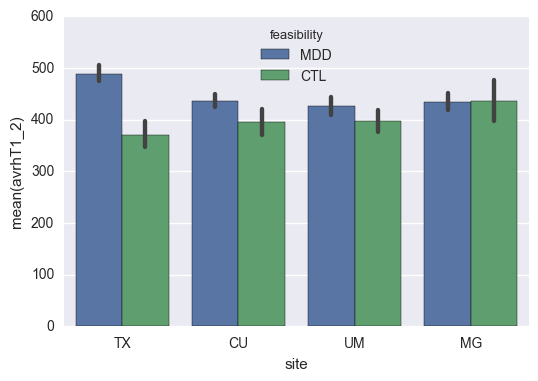

In [134]:
# Rich Trials
rts = sns.barplot(y='avrhT1_2', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avrhT1_2, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


$ANOVA
            Effect DFn DFd        F           p p<.05        ges
1      feasibility   1 286 4.065214 0.044709844     * 0.01401483
2             site   3 286 3.977599 0.008441995     * 0.04005198
3 feasibility:site   3 286 1.063865 0.364776007       0.01103626

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn     SSd        F        p p<.05
1   7 286 115897.7 2901951 1.631746 0.126164      



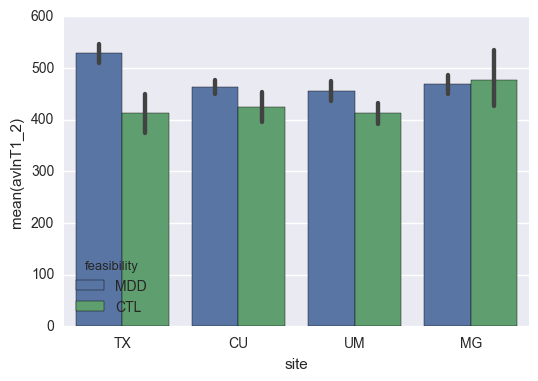

In [135]:
# Lean Trials
rts = sns.barplot(y='avlnT1_2', x = 'site', data=df_firstsess, hue = 'feasibility', ci=68)
%Rpush df_firstsess
%R rt_anova <- ezANOVA(data = df_firstsess, dv = avlnT1_2, between = .(feasibility, site), wid=ProjectSpecificID)
%R print(rt_anova)

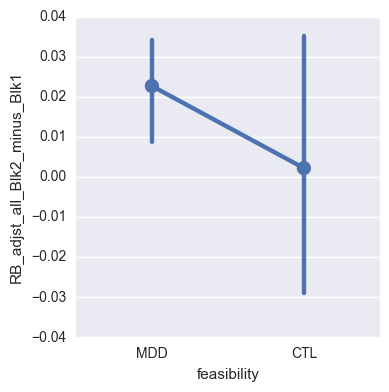

In [93]:
d = sns.factorplot(y='RB_adjst_all_Blk2_minus_Blk1', x= 'feasibility', ci=68, data=df_firstsess)

#### Massachusetts descriptives

count    52.000000
mean      0.009811
std       0.229671
min      -0.615990
25%      -0.154689
50%       0.021437
75%       0.170126
max       0.435866
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64
feasibility       
CTL          count     8.000000
             mean      0.065437
             std       0.148499
             min      -0.151984
             25%      -0.047419
             50%       0.091124
             75%       0.149067
             max       0.291298
MDD          count    44.000000
             mean     -0.000302
             std       0.241438
             min      -0.615990
             25%      -0.183833
             50%       0.005793
             75%       0.170126
             max       0.435866
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64


/Users/mlm2/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


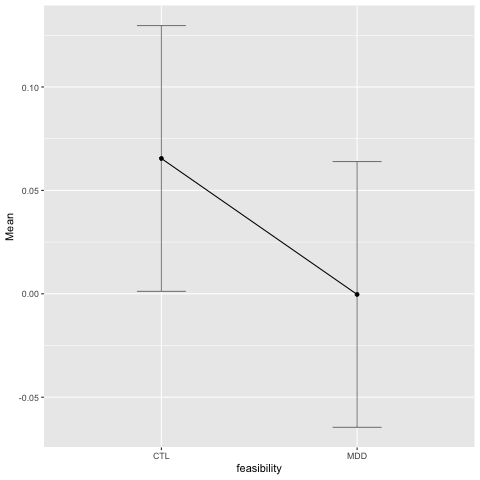

$ANOVA
       Effect DFn DFd        F         p p<.05        ges
1 feasibility   1  50 0.549709 0.4619049       0.01087462

$`Levene's Test for Homogeneity of Variance`
  DFn DFd        SSn       SSd        F         p p<.05
1   1  50 0.03670776 0.9331986 1.966771 0.1669696      



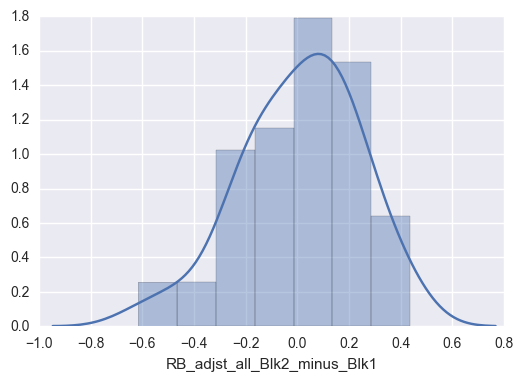

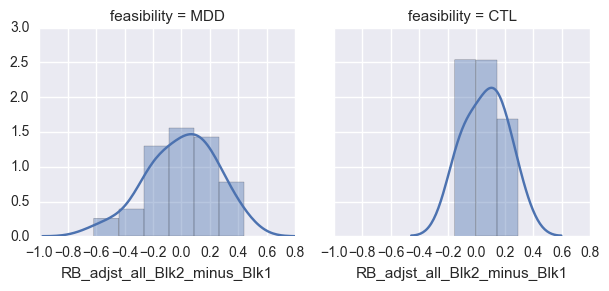

In [92]:
df_mg = df_firstsess[df_firstsess.site == 'MG']

print (df_mg.RB_adjst_all_Blk2_minus_Blk1.describe())

t = df_mg.groupby(['feasibility'])
print (t.RB_adjst_all_Blk2_minus_Blk1.describe())

sns.distplot(df_mg.RB_adjst_all_Blk2_minus_Blk1.dropna())

group_fig = sns.FacetGrid(data=df_mg.dropna(axis=0,subset=['RB_adjst_all_Blk2_minus_Blk1']),col='feasibility',col_wrap=4)
group_fig.map(sns.distplot,'RB_adjst_all_Blk2_minus_Blk1')

%Rpush df_mg
%R cat <- ezPlot(data = df_mg, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, x= feasibility, wid=ProjectSpecificID)
%R print(cat)
%R ay <- ezANOVA(data = df_mg, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, wid=ProjectSpecificID)
%R print(ay)

**Dan note:** Above looks good, sometimes illuminating to overlay the two groups' histograms.

#### New York descriptives

count    87.000000
mean      0.028670
std       0.242198
min      -0.520999
25%      -0.128964
50%       0.035868
75%       0.164572
max       0.638521
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64
feasibility       
CTL          count     9.000000
             mean      0.044479
             std       0.286780
             min      -0.382405
             25%      -0.194625
             50%       0.080845
             75%       0.196364
             max       0.529251
MDD          count    78.000000
             mean      0.026846
             std       0.238618
             min      -0.520999
             25%      -0.124694
             50%       0.033628
             75%       0.161228
             max       0.638521
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64


/Users/mlm2/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


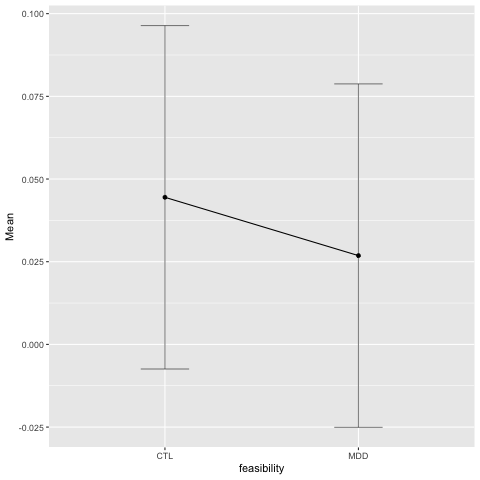

$ANOVA
       Effect DFn DFd          F         p p<.05          ges
1 feasibility   1  85 0.04229347 0.8375531       0.0004973228

$`Levene's Test for Homogeneity of Variance`
  DFn DFd         SSn      SSd         F         p p<.05
1   1  85 0.008300703 1.981847 0.3560111 0.5523158      



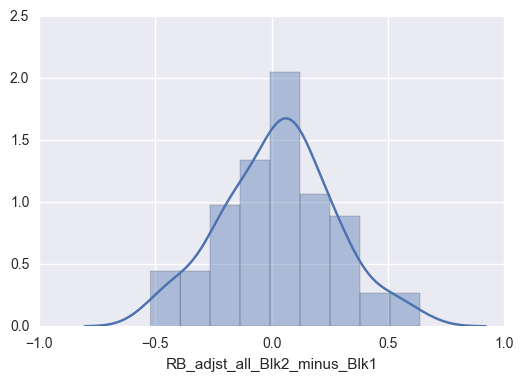

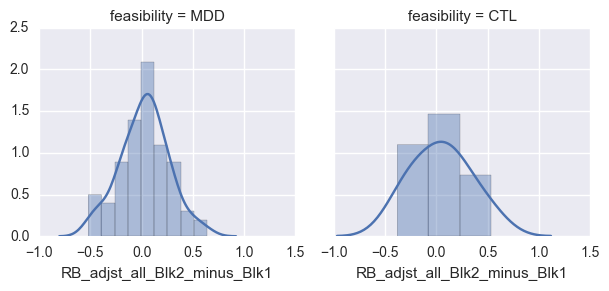

In [78]:
df_cu = df_firstsess[df_firstsess.site == 'CU']
print (df_cu.RB_adjst_all_Blk2_minus_Blk1.describe())

t = df_cu.groupby(['feasibility'])
print (t.RB_adjst_all_Blk2_minus_Blk1.describe())

sns.distplot(df_cu.RB_adjst_all_Blk2_minus_Blk1.dropna())

group_fig = sns.FacetGrid(data=df_cu.dropna(axis=0,subset=['RB_adjst_all_Blk2_minus_Blk1']),col='feasibility',col_wrap=4)
group_fig.map(sns.distplot,'RB_adjst_all_Blk2_minus_Blk1')

%Rpush df_cu
%R cat <- ezPlot(data = df_cu, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, x= feasibility, wid=ProjectSpecificID)
%R print(cat)
%R ay <- ezANOVA(data = df_cu, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, wid=ProjectSpecificID)
%R print(ay)

**Dan note:** That bell curve for everybody's data is so textbook, wow! So far looks like RB is lower in MDDs . . . 

#### Michigan descriptives

count    61.000000
mean      0.061511
std       0.190267
min      -0.383130
25%      -0.040539
50%       0.053141
75%       0.163646
max       0.744152
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64
feasibility       
CTL          count    10.000000
             mean     -0.045982
             std       0.187664
             min      -0.383130
             25%      -0.170711
             50%      -0.016511
             75%       0.077428
             max       0.203814
MDD          count    51.000000
             mean      0.082588
             std       0.185307
             min      -0.246151
             25%      -0.034808
             50%       0.083179
             75%       0.169503
             max       0.744152
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64


/Users/mlm2/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


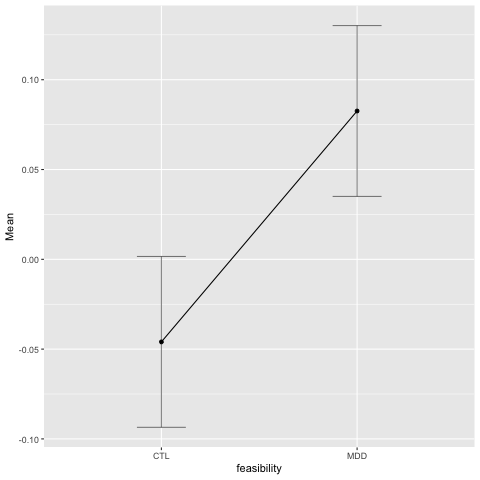

$ANOVA
       Effect DFn DFd        F          p p<.05       ges
1 feasibility   1  59 4.009072 0.04985929     * 0.0636269

$`Levene's Test for Homogeneity of Variance`
  DFn DFd          SSn       SSd            F         p p<.05
1   1  59 1.479326e-05 0.8759509 0.0009964058 0.9749248      



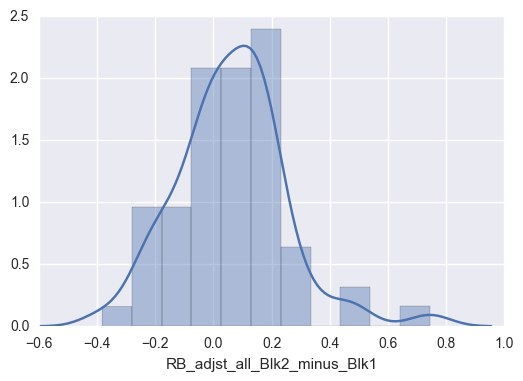

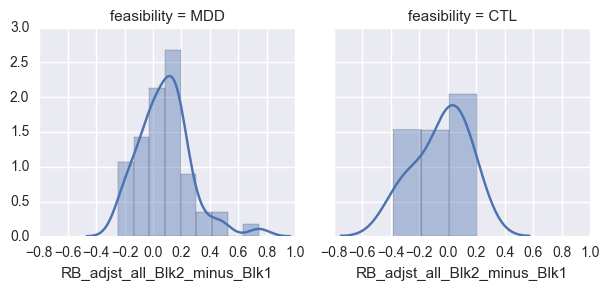

In [79]:
df_um = df_firstsess[df_firstsess.site == 'UM']

print (df_um.RB_adjst_all_Blk2_minus_Blk1.describe())

t = df_um.groupby(['feasibility'])
print (t.RB_adjst_all_Blk2_minus_Blk1.describe())

sns.distplot(df_um.RB_adjst_all_Blk2_minus_Blk1.dropna())

group_fig = sns.FacetGrid(data=df_um.dropna(axis=0,subset=['RB_adjst_all_Blk2_minus_Blk1']),col='feasibility',col_wrap=4)
group_fig.map(sns.distplot,'RB_adjst_all_Blk2_minus_Blk1')

%Rpush df_um
%R cat <- ezPlot(data = df_um, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, x= feasibility, wid=ProjectSpecificID)
%R print(cat)
%R ay <- ezANOVA(data = df_um, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, wid=ProjectSpecificID)
%R print(ay)

#### Texas descriptives

count    94.000000
mean     -0.008711
std       0.166203
min      -0.435213
25%      -0.092147
50%       0.010030
75%       0.103372
max       0.335822
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64
feasibility       
CTL          count     9.000000
             mean     -0.042684
             std       0.106322
             min      -0.246731
             25%      -0.072240
             50%      -0.007195
             75%       0.000000
             max       0.103666
MDD          count    85.000000
             mean     -0.005114
             std       0.171376
             min      -0.435213
             25%      -0.095460
             50%       0.022485
             75%       0.110149
             max       0.335822
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64


/Users/mlm2/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

  warnings.warn(x, RRuntimeWarning)


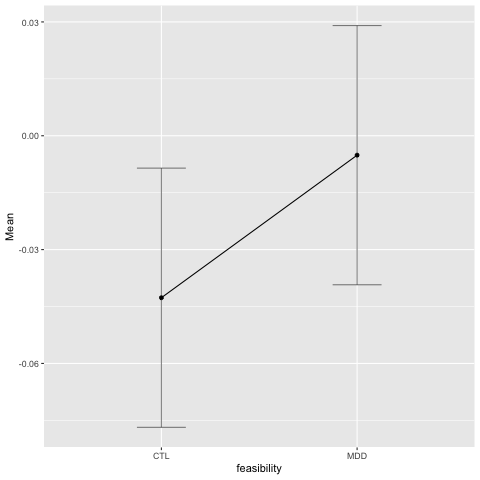

$ANOVA
       Effect DFn DFd         F         p p<.05         ges
1 feasibility   1  92 0.4132294 0.5219338       0.004471539

$`Levene's Test for Homogeneity of Variance`
  DFn DFd        SSn      SSd        F         p p<.05
1   1  92 0.02761408 1.058716 2.399601 0.1247994      



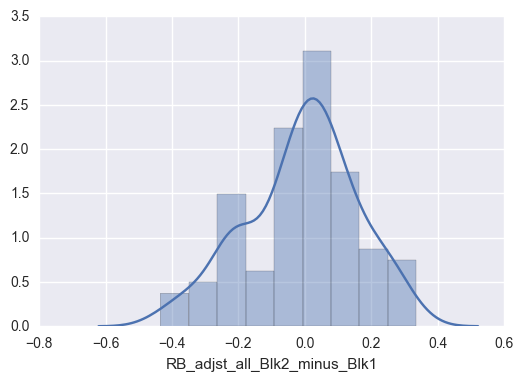

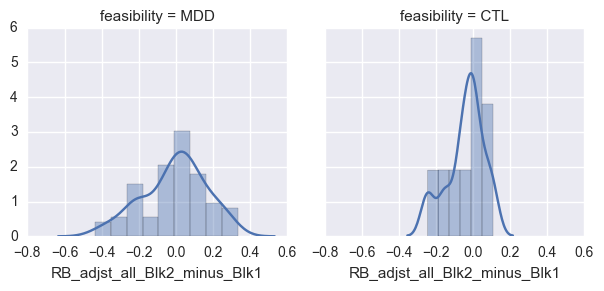

In [80]:
df_tx = df_firstsess[df_firstsess.site == 'TX']

print (df_tx.RB_adjst_all_Blk2_minus_Blk1.describe())

t = df_tx.groupby(['feasibility'])
print (t.RB_adjst_all_Blk2_minus_Blk1.describe())

sns.distplot(df_tx.RB_adjst_all_Blk2_minus_Blk1.dropna())

group_fig = sns.FacetGrid(data=df_tx.dropna(axis=0,subset=['RB_adjst_all_Blk2_minus_Blk1']),col='feasibility',col_wrap=4)
group_fig.map(sns.distplot,'RB_adjst_all_Blk2_minus_Blk1')

%Rpush df_tx
%R cat <- ezPlot(data = df_tx, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, x= feasibility, wid=ProjectSpecificID)
%R print(cat)
%R ay <- ezANOVA(data = df_tx, dv = RB_adjst_all_Blk2_minus_Blk1, between = feasibility, wid=ProjectSpecificID)
%R print(ay)

**Dan note:** Thanks for making a liar out of me, Michigan and Texas . . . Next step with this is to use factorplot to generate bar graphs with ci=68% for RB, with hue=group. Do that once collapsing across site, then do it with col=site (or row=site if that's better). Then if you're up for it, push the data to R and use ezANOVA to run a Group x Site ANOVA (wid=ProjectSpecificID) on the RB data. Everywhere I say "RB", I mean "RB_adjst_all_Blk2_minus_Blk1" (wipes sweat from brow due to over-exertion whilst typing long variable name . . . ) 

In [83]:
# Much better way to get the first session by merging with standard analysis data and taking the first session. I need 
# to move the order of the cells around to make it more intuitive, this should come after the standard analysis stuff.

df_firstsess['date'] = df_firstsess['date1'].replace(to_replace = '_', value ='/', regex = True)
df_firstsess.date.replace(to_replace = '_', value ='/')
df_trial_merged = out.merge(df_firstsess, how = 'outer', on = ['ProjectSpecificID', 'date']) # FIX THE DATE FORMAT AND MERGE 
                                                                                    # ON DATE TOO
df_trial_merged = df_trial_merged[pd.notnull(df_trial_merged['ProjectSpecificID'])]

df_trial_merged = df_trial_merged[pd.notnull(df_trial_merged['feasibility'])]
# renaming time & correct; the hddm package requires specific column names
df_trial_merged.rename(columns={'time':'rt', 'correct': 'response', 'ProjectSpecificID': 'subj_idx'}, inplace = True)

# number of outlier trials and non-outlier trials for the FIRST session
print(df_trial_merged.outlier.value_counts())

# don't include the outlier trials
df_trial_merged = df_trial_merged[df_trial_merged.outlier == '0']
print(df_trial_merged.outlier.value_counts())

# don't include duplicates (a few people in multiple times)
df_trial_merged = df_trial_merged.drop_duplicates()

# THIS IS THE FILE TO USE FOR THE HDDM
df_trial_merged.to_csv('all_trial_first_session_cleaned_merged.csv')

0    59008
1      792
Name: outlier, dtype: int64
0    59008
Name: outlier, dtype: int64


 # Starting the HDDM part

In [99]:
# This file (to my knowledge) is perfect and shouldn't need to be changed in the future
data = hddm.load_csv('all_trial_first_session_cleaned_merged.csv')

# rt needs to be in seconds in order to fit to a model
data['rt'] = data['rt'] / 1000

data.rt

0        0.704
1        0.414
2        0.456
3        0.416
4        0.490
5        0.481
6        0.553
7        0.509
8        0.483
9        0.378
10       0.438
11       0.702
12       0.396
13       0.391
14       0.434
15       0.379
16       0.375
17       0.530
18       0.360
19       0.483
20       0.411
21       0.422
22       0.431
23       0.393
24       0.404
25       0.383
26       0.330
27       0.536
28       0.557
29       0.354
         ...  
57990    0.830
57991    0.589
57992    1.019
57993    0.813
57994    0.701
57995    0.604
57996    1.003
57997    0.910
57998    0.686
57999    0.589
58000    0.764
58001    0.445
58002    1.180
58003    1.005
58004    0.670
58005    0.924
58006    0.700
58007    1.612
58008    1.149
58009    0.540
58010    0.881
58011    0.408
58012    1.339
58013    0.542
58014    0.732
58015    0.686
58016    0.365
58017    0.846
58018    0.414
58019    1.083
Name: rt, dtype: float64

In [85]:
print (hddm.__version__)

0.6.0


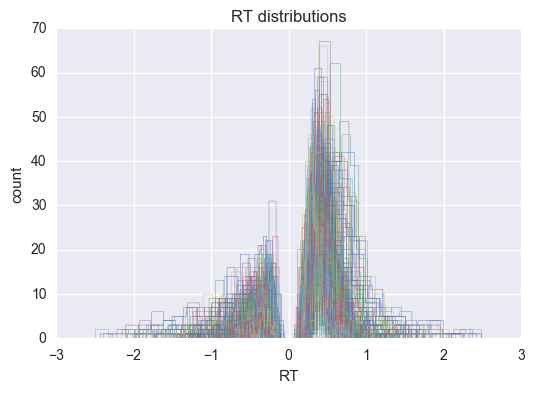

In [86]:
#flip error RTs so they become negative
data = hddm.utils.flip_errors(data)
# is this something that should be undone??


#plot the RTs and save them 
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'): 
    subj_data.rt.hist(bins=30, histtype='step', ax=ax)
plt.savefig('RT_dist.pdf')

In [87]:
#creates a simple model that doesn't take conditions into account
m=hddm.HDDM(data)

In [88]:
# this part has to do with Markov-Chain Monte Carlo (MCMC; https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)
# it seems like MCMC gets the distribution of the posterior probababilities, which seem like 

m.find_starting_values()
m.sample(2000, burn=20)

/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 1097.9 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [95]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.MG0001', 'a_subj.MG0002', 'v'])]

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.13202,0.0112771,1.11029,1.12422,1.13194,1.13989,1.15395,0.000326828
a_std,0.189388,0.00834352,0.173922,0.183451,0.188979,0.194781,0.206034,0.000242843
v,1.33335,0.0360775,1.2631,1.30881,1.33364,1.35761,1.40498,0.000906392


Plotting a
Plotting a_std
Plotting v
Plotting t


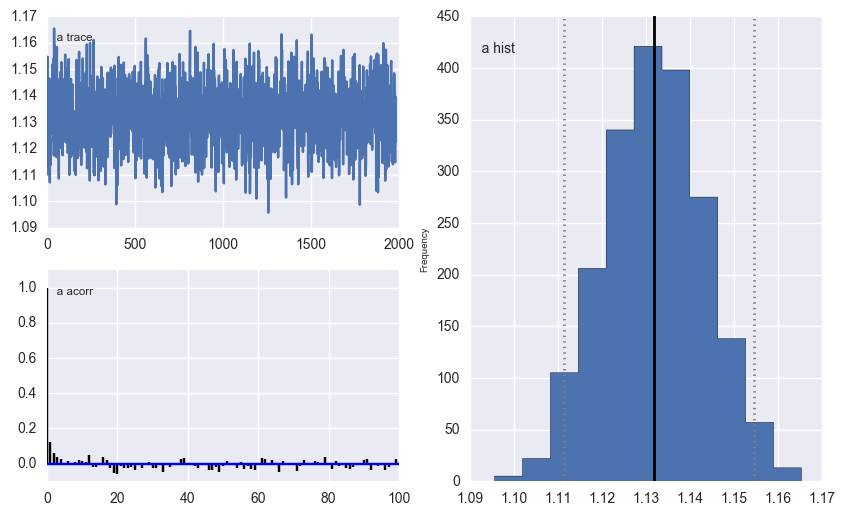

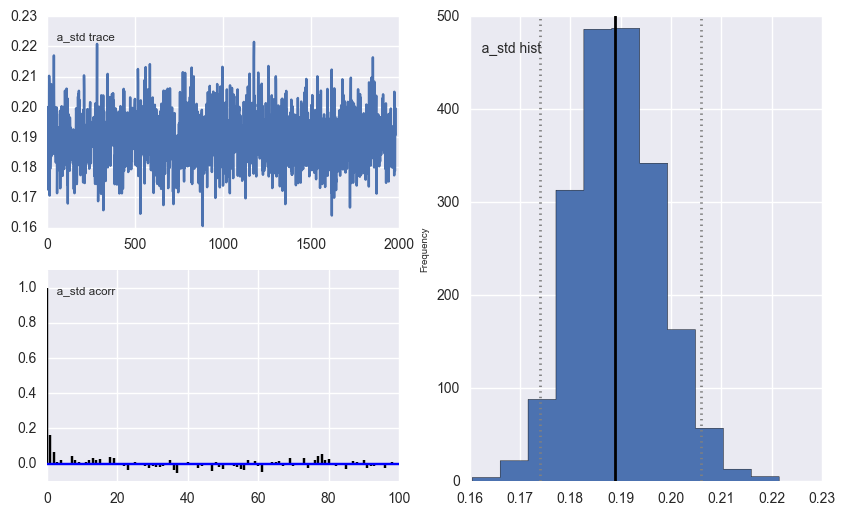

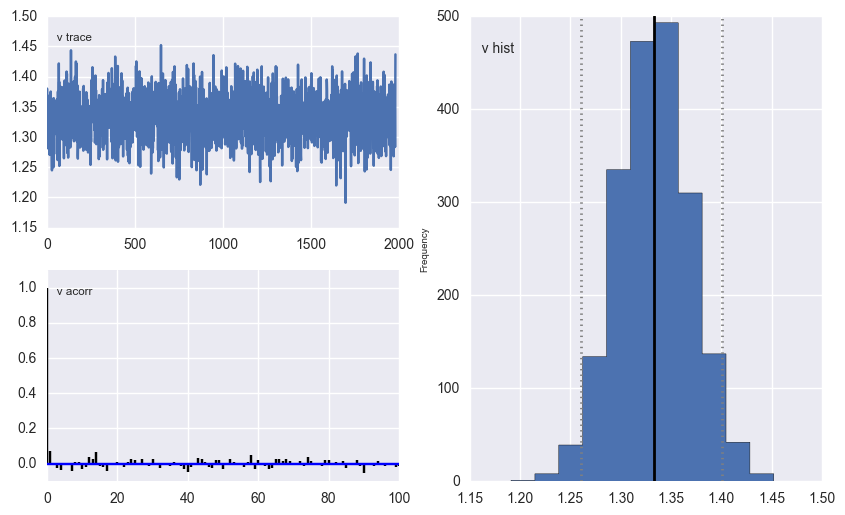

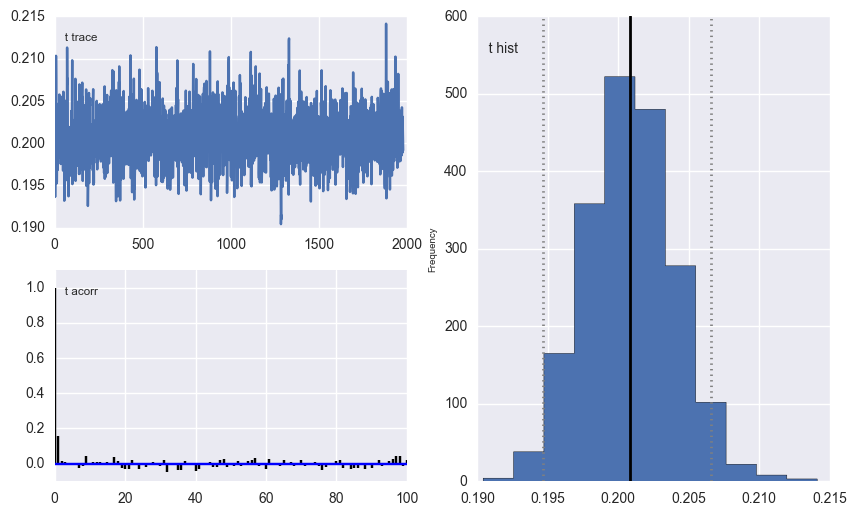

In [96]:
#From Demo:

# "The inference algorithm, MCMC, requires the chains of the model to have properly converged. 
#While there is no way to guarantee convergence for a finite set of samples in MCMC, there are 
#many heuristics that allow you identify problems of convergence. One main analysis to look at 
#is the trace, the autocorrelation, and the marginal posterior. You can plot these using the 
#plot_posteriors() function."

m.plot_posteriors(['a', 't', 'v', 'a_std'])

#we are looking for drifts or large jumps, based off of the example they gave it looks like 
#we're good

In [ ]:
# TAKES FOREVER--don't do unless you need to. There might be something wrong here, it really 
# shouldn't take this long. 

# "The Gelman-Rubin statistic provides a more formal test for convergence that compares the 
# intra-chain variance to the intra-chain variance of different runs of the same model."

models = []

for i in range(5):
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(5000, burn = 20)
    models.append(m)

#Values should be close to 1, and they are. 
hddm.analyze.gelman_rubin(models)

In [ ]:
# for time's sake, I used 1000 & 100 to test, but it should really be 10000 & 1000
m_stim = hddm.HDDM(data, depends_on={'v': 'length'})
m_stim.find_starting_values()
m_stim.sample(1000, burn=100)

In [ ]:
v_short, v_long = m_stim.nodes_db.node[['v(short)', 'v(long)']]
hddm.analyze.plot_posterior_nodes([v_short, v_long])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('long_short_drift_rate.pdf')

# think this makes sense because the short one is the rich stim always
# we are treating short/long like a between subjects factor though, so we should redo it, not
# sure how

## Within model (rich vs. lean)

In [115]:
from patsy import dmatrix
dmatrix("C(length, Treatment('short'))", data.head(10))

DesignMatrix with shape (10, 2)
  Intercept  C(length, Treatment('short'))[T.long]
          1                                      0
          1                                      1
          1                                      0
          1                                      1
          1                                      0
          1                                      0
          1                                      0
          1                                      1
          1                                      0
          1                                      0
  Terms:
    'Intercept' (column 0)
    "C(length, Treatment('short'))" (column 1)

In [118]:
data = hddm.load_csv('all_trial_first_session_cleaned_merged.csv')
dmatrix("C(length, Treatment ('short'))", data)
data['rt'] = data['rt'] / 1000
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(length, Treatment ('short'))")

m_within_subj.sample(5000, burn=200)

Adding these covariates:
['v_Intercept', "v_C(length, Treatment('short'))[T.long]"]


/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5001 of 5000 complete in 21684.5 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [120]:
m_within_subj.save('within_model')

ValueError: db is 'ram'. Saving a model requires a database on disk.

## Between Model with feasibility

In [121]:
# for time's sake, I used 1000 & 100 to test, but it should really be 10000 & 1000

m_stim = hddm.HDDM(data, depends_on={'v': 'feasibility', 'a': 'feasibility'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)

/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10001 of 10000 complete in 3395.3 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [119]:
m_stim.save('feasibility_model') # need to redo the model in order to save it...ugh

ValueError: db is 'ram'. Saving a model requires a database on disk.

P_v(MDD > CTL) =  0.000444444444444
P_v(CTL > MDD) =  0.999555555556


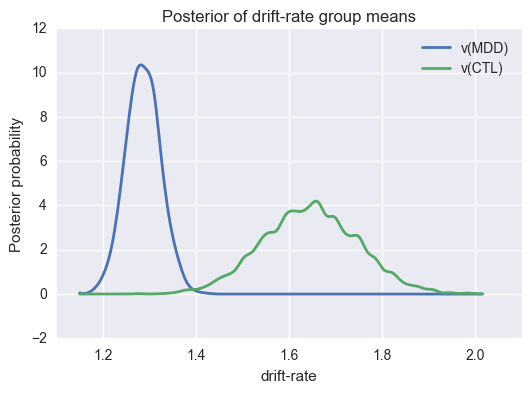

In [122]:
v_MDD, v_CTL = m_stim.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('ctl_mdd_drift_rate_more_samples.pdf')

# Since HDDM uses Bayesian estimation it is straight forward to analyze the posterior directly for hypothesis testing. 
# You can directly work with the posterior and ask statistically meaningful questions. For example, assume you 
# two conditions for drift-rate:
print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())


# From website: "Note that it is wrong to just input the subject parameters of a hierarchical into a frequentist 
# test like the T-test. The hierarchical model violates the independence assumption."
# I'm reading the BEST, 2012 paper and it seems like 95% is still the cutoff. 

#I think this will be  a little smoother when we run it with a larger sample

P_a(MDD > CTL) =  0.997111111111
P_a(CTL > MDD) =  0.00288888888889


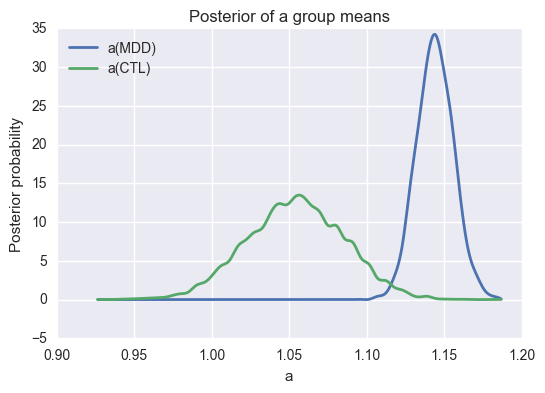

In [124]:
a_MDD, a_CTL = m_stim.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of a group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())